# Particle Swarm Optimization

# Index
- [Functions' domain](#Functions'-domain)
- [Functions](#Functions)
- [Parameters](#Parameters) 
- [Particle](#Particle)
- [Swarm](#Swarm)
- [PSO Visualization](#PSO-Visualization)
- [Results](#Results)

# Functions' domain

In [1]:
from IPython.display import Image

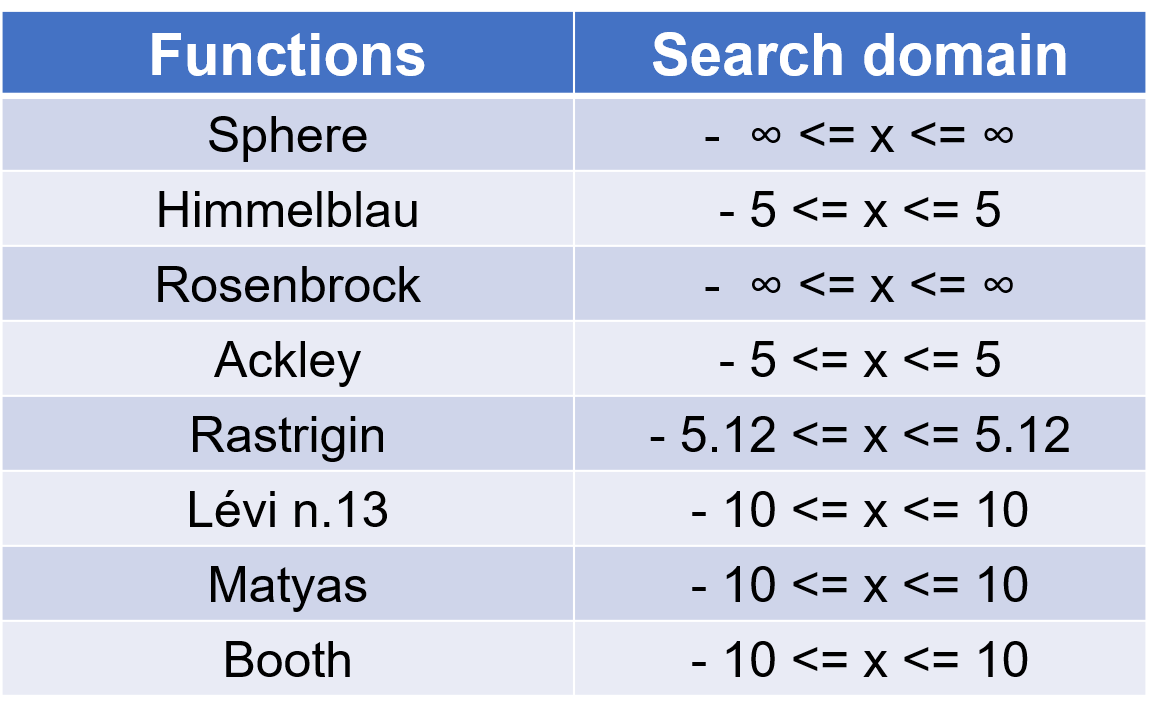

In [2]:
PATH = "C:\\Users\EDSON MAXIMINO\Pictures"
Image(filename = PATH + "/funcoes.png", width=600, height=100)

In [ ]:
from math import cos, pi
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits import mplot3d
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib.animation import FuncAnimation
%matplotlib notebook

## Functions

In [ ]:
# Objective functions to be optimized
def sphere(x):
    return sum(i * i for i in x)

def rastrigin(x):
    return 10 * len(x) + sum(i * i - 10 * cos(2 * pi * i) for i in x)

def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

def rosenbrock(x):
    dim = len(x)
    sum = 0
    for i in range(dim-1):
        sum+= 100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return sum


def ackley(x):
    dim = len(x)
    sum1 = 0
    sum2 = 0
    for i in range(dim):
        sum1 += x[i]**2
        sum2 += np.cos(2*np.pi*x[i])

    return -20*np.exp(-0.2*np.sqrt(sum1/dim)) - np.exp(sum2/dim) + 20 + np.e

def levi13(x):
    return np.sin(3*np.pi*x[0])**2 + (x[0] - 1)**2*(1 + np.sin(3*np.pi*x[1])**2) + (x[1] - 1)**2*(1 + np.sin(2*np.pi*x[1])**2)

def matyas(x):
    return (0.26 * (x[0]**2 + x[1]**2)) - (0.48 * x[0] * x[1])

def booth(x):
    return ((x[0] + 2*x[1] - 7)**2) + ((2*x[0] + x[1] +-5)**2)

## Parameters

In [ ]:
NPARTICLE = 20
DIM = 2
RANGE = (-5, 5)
NITERATION = 200
VMAX = (RANGE[1] - RANGE[0]) / 2.0

C1 = 2.05
C2 = 2.05
WRANGE = (.4, .9)
W = [WRANGE[1] - (WRANGE[1] - WRANGE[0]) * i / NITERATION for i in range(NITERATION)]

## Particle

In [ ]:
class Particle:

    # contructor
    def __init__(self, f, n=None, x=None):
        if n is not None:
            self.n = n
        else:
            self.n = DIM

        # store objective function
        self.f = f

        # start position at random
        if x is not None:
            self.x = x * np.ones(self.n)  # change to array-like
        else:
            self.x = RANGE[0] + (RANGE[1] - RANGE[0]) * np.random.random(self.n)

        # evaluate position
        self.evaluate()

        # start velocity with 0
        self.v = np.zeros(self.n)

        # deep copy the current position as best personal and fitness
        self.m = copy.deepcopy(self.x)
        self.fit_m = self.fit_x

    def __str__(self):
        return "X: " + str([round(i, 4) for i in self.x]) + \
               "\nFITX: " + str("{:.4e}".format(self.fit_x))

    #               "\nM: " + str([round(i, 4) for i in self.m]) + \
    #               "\nFITM: " + str("{:.4e}".format(self.fit_m)) + \
    #               "\nV: " + str([round(i, 4) for i in self.v])

    def getCopy(self):
        return copy.deepcopy(self)

    def evaluate(self):
        self.fit_x = self.f(self.x) # find fit_x for certain positions in the search space

## Swarm

In [ ]:
class Swarm:

    def __init__(self, f, n=None):
        if n is not None:
            self.n = n
        else:
            self.n = NPARTICLE

        self.f = f
        self.particles = []

    def initialize(self):
        for i in range(self.n):
            self.particles.insert(i, Particle(self.f)) # insert self.x and self.fit_x into the array called particles. 

    def avgFitness(self):
        return sum(p.fit_x for p in self.particles) / float(self.n)

    def stdFitness(self, avg=None):
        if avg is None:
            avg = self.avgFitness()
        return math.sqrt(sum((p.fit_x - avg) ** 2 for p in self.particles) / float(self.n - 1))

    def printFitness(self):
        print(["{:.4e}".format(p.fit_x) for p in self.particles])

## PSO Visualization

In [ ]:
"""
Created on Tue Aug 23 09:44:04 2018
@author: Reginaldo Santos
@description: Rotational variant PSO algorithm with fast information exchange
"""

"""   
      Declarations and definitions of PSO functions   
        Modified and adapted by: Gabriela Maximino   
"""

# Update the velocity of a particle
def updateVelocity(i, p, g):
    r1 = np.random.random(DIM)
    r2 = np.random.random(DIM)
    p.v = W[i] * p.v + \
          C1 * r1 * (p.m - p.x) + \
         C2 * r2 * (g.x - p.x)
    # p.v = 1e-1 * p.v
    for i in range(DIM):
        if (np.abs(p.v[i]) > VMAX):
            p.v[i] = np.sign(p.v[i]) * VMAX

# Move a particle in the search space
def move(p):
    p.x = p.x + p.v
    for i in range(DIM):
        if (p.x[i] < RANGE[0]):
            p.x[i] = RANGE[0]
        if (p.x[i] > RANGE[1]):
            p.x[i] = RANGE[1]


# Evaluate a particle
def evaluate(p):
    p.evaluate()


# Update local and global best memories
def updatePBAndGB(p, g):
    if (p.fit_x <= p.fit_m):
        p.m = copy.deepcopy(p.x)
        p.fit_m = p.fit_x
        if (p.fit_x <= g.fit_x):
            g.x = copy.deepcopy(p.x)
            g.fit_x = p.fit_x


# Find the best particle from the swarm
def getGlobalBest(swarm):
    fits = [p.fit_x for p in swarm.particles]
    i = fits.index(min(fits))
    return swarm.particles[i].getCopy()


# Create 2D/3D contour to visualize PSO's procedures
def Visualization(type):
    if type == '2d':
        fig, ax = plt.subplots()
        ax.contour(xx, yy, zz, 60)
        plt.xlabel("Variable X")
        plt.ylabel("Variable Y")

        # plot the swarm and the global best particle
        pos = np.matrix([[swarm.particles[j].x[0], swarm.particles[j].x[1]] for j in range(NPARTICLE)])
        points1, = ax.plot(pos[:, 0], pos[:, 1], 'ob')  # swarm
        points2, = ax.plot(g.x[0], g.x[1], 'xr', markersize=8)  # global best

        def update(i):
            plt.title("Iteration: " + str(i + 1))
            for j in range(NPARTICLE):
                updateVelocity(i, swarm.particles[j], g)
                move(swarm.particles[j])
                evaluate(swarm.particles[j])
                updatePBAndGB(swarm.particles[j], g)
            avg[i] = swarm.avgFitness()
            std[i] = swarm.stdFitness(avg[i])
            bfit[i] = g.fit_x
            # update particles' position
            pos = np.matrix([[swarm.particles[j].x[0], swarm.particles[j].x[1]] for j in range(NPARTICLE)])
            points1.set_data(pos[:, 0], pos[:, 1])
            points2.set_data(g.x[0], g.x[1])
            return points1, points2
            
    elif type == '3d':
        fig = plt.figure(1)
        ax = plt.axes(projection='3d', elev=36, azim=-133)
        graph = ax.contour3D(xx, yy, zz, 200, alpha=0.3, cmap=cm.jet)
        cbar = fig.colorbar(graph)
        ax.set_xlabel('Variable X')
        ax.set_ylabel('Variable Y')
        ax.set_zlabel('Z (F(x, y)');
        time_text = ax.text(0.5, 0.5, 0.5, '', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        sc = ax.scatter([p.x[0] for p in swarm.particles], [p.x[1] for p in swarm.particles],
                        [p.fit_x for p in swarm.particles], s=7, c='k', alpha=1)
        rg = ax.scatter([g.x[0]], [g.x[1]], [g.fit_x], s=50, alpha=1, marker='x', c='r')
        def update(i):
            time_text.set_text("Iteration: " + str(i+1))
            for j in range(NPARTICLE):
                updateVelocity(i, swarm.particles[j], g)
                move(swarm.particles[j])
                evaluate(swarm.particles[j])
                updatePBAndGB(swarm.particles[j], g)
            avg[i] = swarm.avgFitness()
            std[i] = swarm.stdFitness(avg[i])
            bfit[i] = g.fit_x
            # update particles' position
            rg._offsets3d = ([g.x[0]], [g.x[1]], [g.fit_x]) 
            sc._offsets3d = ([p.x[0] for p in swarm.particles], [p.x[1] for p in swarm.particles], [p.fit_x for p in swarm.particles])
            return rg, sc
    anim = FuncAnimation(fig, update, frames=NITERATION, repeat=False, blit=True)
    return anim

"""   Main iteration of the algorithm   """
f = ackley # Choose the function you want to optimize
swarm = Swarm(f, NPARTICLE)
swarm.initialize()
g = getGlobalBest(swarm)
avg = np.zeros(NITERATION)
std = np.zeros(NITERATION)
bfit = np.zeros(NITERATION)

r = np.arange(RANGE[0] - 1, RANGE[1] + 1, 0.1)
xx, yy = np.meshgrid(r, r)
zz = copy.deepcopy(xx)
for i in range(xx.shape[0]):
    zz[i, :] = [f([xx[i, j], yy[i, j]]) for j in range(xx.shape[1])]

Visualization('3d') # You can switch between 2d and 3d

## Results

In [ ]:
"""   Results and plots   """
t = range(NITERATION)
plt.figure(2)

# Plot best particle through iterations
plt.subplot(211)
plt.plot(t, bfit)
plt.yscale('log')
plt.grid(True)
plt.xlabel("Iterations")
plt.ylabel("Best particle fitness")

# Plot average fitness through iterations
plt.subplot(212)
plt.plot(t, avg)
plt.fill_between(t, avg + std, avg - std, facecolor='red', alpha=0.5)
plt.grid(True)
plt.xlabel("Iterations")
plt.ylabel("Average fitness")

plt.show()
print("Best result found")
print(g)